In [31]:
# !pip install dspy-ai cloudpickle matplotlib

In [1]:
# Import relevant packages
# DSPy
import dspy
from dspy.signatures.signature import signature_to_template

import random
import pandas as pd

# Setting up LLM models
PROJECT_ID = "wiq-gen-ai-rd-dev"

MODEL_ID = "gemini-1.5-flash-001"
# MODEL_ID = "gemini-1.5-pro-001"

flash = dspy.GoogleVertexAI(
    model=MODEL_ID, 
    max_tokens=1000,
    temperature=0.05, 
    project=PROJECT_ID
)

# Note: different models can be set for prompt model and task model
# - prompt model : rm (retrieval model) 
# - task model : lm (language model)
dspy.settings.configure(lm=flash, rm=flash)

# Fixed themes used for signatures
themes = """
    Technical Learning Resources,
    Clarity of Requirements,
    Time Commitment / Workload,
    Showcase / Presentation Format,
    Communication and Information Sharing,
    Team Formation and Dynamics,
    Relevance of Training Content,
    Application to Business / Use Cases,
    Accessibility and Inclusion,
    Incentives and Recognition,
    Post-Hackathon Follow-up,
    Support from Leadership / Mentors,
"""

c:\Users\atan\Documents\wiqlabs-summarize-verbatim\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define Task

This will be used for our task model and a simple chain of thought should be sufficient as it doesn't really need to load additional data or context to help classify.

In [2]:
# Setting up signature for DSPy
class GenerateTheme(dspy.Signature):
    """Classify user feedback from hackathon to one single theme"""
    comments = dspy.InputField(desc="user feedback from hackathon")
    themes = dspy.OutputField(desc=f"only pick one of the following choices: {themes}")


class FollowupQuery(dspy.Signature):
    """Generate a query which is conducive to classifying the comment"""

    context = dspy.InputField(desc=f"contains relevant facts to classify comments from hackathon to {themes}")
    comments = dspy.InputField(desc="user feedback from hackathon")
    search_query = dspy.OutputField(desc="Judge if the context is adequate to classify user comments, if not adequate or if it is blank, generate a search query that would help you classify the comments")

In [3]:
## Vanilla
class Vanilla(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate_answer = dspy.Predict(GenerateTheme)
    
    def forward(self, comments):
        answer = self.generate_answer(comments=comments)
        theme = answer.themes.split("Themes: ",1)[1].strip()
        return dspy.Prediction(answer=theme)
    
vanilla = Vanilla()

## COT
class COT(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate_answer = dspy.ChainOfThought(GenerateTheme)
    
    def forward(self, comments):
        answer = self.generate_answer(comments=comments)
        return dspy.Prediction(answer=answer.themes)
    
cot = COT()

## ReAct
class ReAct(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate_answer = dspy.ReAct(GenerateTheme)
    
    def forward(self, comments):
        answer = self.generate_answer(comments=comments)
        return dspy.Prediction(answer=answer.themes)
    
react = ReAct()


## BasicMultiHop
class BasicMultiHop(dspy.Module):
    def __init__(self, num_passages=3):
        self.retrieve = dspy.Retrieve(k=num_passages)
        self.generate_query = dspy.ChainOfThought(FollowupQuery)
        self.generate_answer = dspy.ChainOfThought(GenerateTheme)

    def forward(self, comments):
        context = []

        for hop in range(2):
            query = self.generate_query(context=context, comments=comments).search_query
            context += self.retrieve(query).passages

        answer = self.generate_answer(context=context, comments=comments)
        return dspy.Prediction(answer=answer.themes)
    
multihop = BasicMultiHop(num_passages=3)


In [4]:
# Test a question
rag = cot
pred = rag.forward(
    "The topic and content was very interesting and the opportunity to connect with technical and commercial mentors was great! In the future, it would be great to see either more structure to the hackathon, or more communication about the structure of the hackathon."
)
pred
# Check prompt history
# flash.inspect_history(n=1)

Prediction(
    answer='**Clarity of Requirements**'
)

2) Load training and testing data

In [8]:
# Create training and testing dataset
from dspy.datasets import DataLoader

# random.seed(42)

# Convert csv to dataframe
data = pd.read_csv("./golden_dataset.csv")
# data = pd.read_csv("./data.csv")
dataset = data[["comments", "answer"]] # only want the relevant columns
dataset = dataset[
    dataset.comments.notna() & dataset.answer.notna()
]
# dataset = dataset.head(5) # limit dataset for testing

# Load data into the desired format for DSPy
dl = DataLoader()
hackathon_dataset = dl.from_pandas(dataset, fields=("comments", "answer"), input_keys=['comments']) # IMPORTANT: input_keys is the 'input' for the model
splits = dl.train_test_split(hackathon_dataset, train_size=0.8) # `dataset` is a List of dspy.Example
train_dataset = splits['train']
test_dataset = splits['test']

dataset.describe()

,comments,answer
count,77,77
unique,77,11
top,Overall very enjoyable. Organisation was quite...,Time Commitment / Workload
freq,1,18


In [ ]:
# # Evaluate the accuracy - calculates the HIT ratio (i.e. exact match of the predicted answer)
# from dspy.evaluate.evaluate import Evaluate

# # Set up the `evaluate_rag` function. We'll use this many times below.
# evaluate_rag = Evaluate(devset=test_dataset, num_threads=1, display_progress=True, display_table=5)

# # Evaluate the `compiled_rag` program with the `answer_exact_match` metric.
# metric = dspy.evaluate.answer_exact_match
# evaluation_score = evaluate_rag(cot, metric=metric)
# print(f"Retrieval HIT Ratio for RAG: {evaluation_score}%")

3) Optimizing with MIPRO

In [9]:
from dspy.teleprompt import MIPROv2

# Constants for optimisers
num_threads = 2
kwargs = dict(num_threads=num_threads, display_progress=True, display_table=5)
metric = dspy.evaluate.answer_exact_match

optimiser = MIPROv2(
                task_model=flash,
                prompt_model=flash,
                metric=metric,
                log_dir="hackathon/"
            )

compiled_model = optimiser.compile(
                    student=cot, 
                    trainset=train_dataset, 
                    max_bootstrapped_demos=4, 
                    max_labeled_demos=4, 
                    eval_kwargs=kwargs,
                )


Please be advised that based on the parameters you have set, the maximum number of LM calls is projected as follows:


- Prompt Model: 10 data summarizer calls + 10 * 1 lm calls in program + (2) lm calls in program aware proposer = 22 prompt model calls
- Task Model: 25 examples in minibatch * 30 batches + 61 examples in train set * 3 full evals = 933 task model calls

Estimated Cost Calculation:

Total Cost = (Number of calls to task model * (Avg Input Token Length per Call * Task Model Price per Input Token + Avg Output Token Length per Call * Task Model Price per Output Token) 
            + (Number of calls to prompt model * (Avg Input Token Length per Call * Task Prompt Price per Input Token + Avg Output Token Length per Call * Prompt Model Price per Output Token).

For a preliminary estimate of potential costs, we recommend you perform your own calculations based on the task
and prompt models you intend to use. If the projected costs exceed your budget or expectations, you may c

 15%|█▍        | 9/61 [00:12<01:10,  1.36s/it]


Bootstrapped 4 full traces after 10 examples in round 0.


  8%|▊         | 5/61 [00:04<00:55,  1.01it/s]


Bootstrapped 4 full traces after 6 examples in round 0.


  7%|▋         | 4/61 [00:03<00:53,  1.06it/s]


Bootstrapped 2 full traces after 5 examples in round 0.


  5%|▍         | 3/61 [00:06<01:58,  2.03s/it]


Bootstrapped 1 full traces after 4 examples in round 0.


 10%|▉         | 6/61 [00:12<01:57,  2.14s/it]


Bootstrapped 2 full traces after 7 examples in round 0.


  8%|▊         | 5/61 [00:07<01:20,  1.44s/it]


Bootstrapped 2 full traces after 6 examples in round 0.


 13%|█▎        | 8/61 [00:14<01:33,  1.76s/it]


Bootstrapped 3 full traces after 9 examples in round 0.


  3%|▎         | 2/61 [00:03<01:33,  1.59s/it]


Bootstrapped 1 full traces after 3 examples in round 0.
Using a randomly generated configuration for our grounded proposer.
Selected tip: description
PROGRAM DESCRIPTION: ## SUMMARY OF PROGRAM ABOVE:

This program appears to be designed to **classify user feedback from a hackathon into one single theme**. It utilizes a language model (the `GenerateTheme` function within the `ChainOfThought` class) to generate a rationale and categorize the feedback based on a predefined set of themes. 

Here's how it works:

1. **Input:** The program takes user comments from a hackathon as input.
2. **Rationale Generation:**  A language model (presumably a large language model powered by `GenerateTheme`) analyzes the input comments and generates a **"rationale"**.  This rationale explains the reasoning behind the chosen theme.
3. **Theme Selection:** The program then analyzes the rationale and uses the language model to select one of the pre-defined themes. The available themes are:
    * Technical Lea

c:\Users\atan\Documents\wiqlabs-summarize-verbatim\.venv\Lib\site-packages\optuna\_experimental.py:30: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-09-12 09:08:26,880] A new study created in memory with name: no-name-193d662e-dbdf-438d-acd8-d6af35c278e6
INFO:root:Starting trial num: 0
Starting trial num: 0
INFO:root:instruction_idx 1
instruction_idx 1
INFO:root:demos_idx 2
demos_idx 2


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:

Analyze the provided hackathon user feedback and, based on it, provide a step-by-step explanation (Chain of Thought) for why the feedback aligns with a single theme among the following options: 

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors 
 
Then, list the corresponding theme in your output. Remember to follow the provided structure:

"Reasoning: [explain your reasoning for choosing a specific theme] 
Themes: [selected theme based on your reasoning]
p: Themes:


...
[('generate_answer', Predict(StringSignature(comments -> rationale, themes
    instructions='Classify user feedback from hackathon 

Average Metric: 12 / 25  (48.0): 100%|██████████| 25/25 [00:15<00:00,  1.59it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:08:42.648230Z [info     ] Average Metric: 12 / 25 (48.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:08:42.648230Z [info     ] Average Metric: 12 / 25 (48.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:08:43.976245Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:08:43.976245Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
DEBUG:matplotlib:matplotlib data path: c:\Users\atan\Documents\wiqlabs-summarize-verbatim\.venv\Lib\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:CONFIGDIR=C:\Users\atan\.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is win32
DEBUG:matplotlib:CACHEDIR=C:\Users\atan\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\atan\.matplotlib\fontlist-v390.json


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION:

Analyze the provided hackathon user feedback and, based on it, provide a step-by-step explanation (Chain of Thought) for why the feedback aligns with a single theme among the following options: 

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors 
 
Then, list the corresponding theme in your output. Remember to follow the provided structure:

"Reasoning: [explain your reasoning for choosing a specific theme] 
Themes: [selected theme based on your reasoning]

---

Follow the following format.

Comments: user feedback from hackathon

Reasoning: Let's think step by step in order to ${produce the themes}. We ...

Themes: only pick one of

Average Metric: 45 / 61  (73.8): 100%|██████████| 61/61 [00:35<00:00,  1.73it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:09:20.062179Z [info     ] Average Metric: 45 / 61 (73.8%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:09:20.062179Z [info     ] Average Metric: 45 / 61 (73.8%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


[('generate_answer', Predict(StringSignature(comments -> rationale, themes
    instructions='Classify user feedback from hackathon to one single theme'
    comments = Field(annotation=str required=True json_schema_extra={'desc': 'user feedback from hackathon', '__dspy_field_type': 'input', 'prefix': 'Comments:'})
    rationale = Field(annotation=str required=True json_schema_extra={'prefix': "Reasoning: Let's think step by step in order to", 'desc': '${produce the themes}. We ...', '__dspy_field_type': 'output'})
    themes = Field(annotation=str required=True json_schema_extra={'desc': 'only pick one of the following choices: \n    Technical Learning Resources,\n    Clarity of Requirements,\n    Time Commitment / Workload,\n    Showcase / Presentation Format,\n    Communication and Information Sharing,\n    Team Formation and Dynamics,\n    Relevance of Training Content,\n    Application to Business / Use Cases,\n    Accessibility and Inclusion,\n    Incentives and Recognition,\n    P

Average Metric: 44 / 61  (72.1): 100%|██████████| 61/61 [00:35<00:00,  1.73it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:09:55.282063Z [info     ] Average Metric: 44 / 61 (72.1%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:09:55.282063Z [info     ] Average Metric: 44 / 61 (72.1%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
[I 2024-09-12 09:09:55,309] Trial 0 finished with value: 48.0 and parameters: {'0_predictor_instruction': 1, '0_predictor_demos': 2}. Best is trial 0 with value: 48.0.
INFO:root:Starting trial num: 1
Starting trial num: 1
INFO:root:instruction_idx 6
instruction_idx 6
INFO:root:demos_idx 2
demos_idx 2


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION: 

To understand user feedback from a hackathon and categorize it into a single theme, follow these steps.  Firstly, consider the feedback provided -  analyze it to identify its main focus. Examine which specific aspect of the hackathon is being highlighted: whether it's learning, technical resources, collaboration, presentation format, time management, communication effectiveness, or something else.  Then, select the *one*  theme that best captures the essence of this feedback from the list below: 

**Potential Themes:**

* **Technical Learning Resources:** This includes discussions around utilizing new technical tools, expanding technical skills and knowledge, and accessing learning opportunities via the hackathon format.
* **Clarity of Requirements:** Feedback pertaining to difficulties navigating project directions, uncertainties stemming from project goals and instructions. 
* **Time Commitment / Workload:** Concerns relate

Average Metric: 17 / 25  (68.0): 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:10:10.255035Z [info     ] Average Metric: 17 / 25 (68.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:10:10.255035Z [info     ] Average Metric: 17 / 25 (68.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:10:11.427339Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:10:11.427339Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION: 

To understand user feedback from a hackathon and categorize it into a single theme, follow these steps.  Firstly, consider the feedback provided -  analyze it to identify its main focus. Examine which specific aspect of the hackathon is being highlighted: whether it's learning, technical resources, collaboration, presentation format, time management, communication effectiveness, or something else.  Then, select the *one*  theme that best captures the essence of this feedback from the list below: 

**Potential Themes:**

* **Technical Learning Resources:** This includes discussions around utilizing new technical tools, expanding technical skills and knowledge, and accessing learning opportunities via the hackathon format.
* **Clarity of Requirements:** Feedback pertaining to difficulties navigating project directions, uncertainties stemming from project goals and instructions. 
* **Time Commitment / Workload:** Concerns related to the amount of work needed 

[I 2024-09-12 09:10:11,470] Trial 1 finished with value: 68.0 and parameters: {'0_predictor_instruction': 6, '0_predictor_demos': 2}. Best is trial 1 with value: 68.0.
INFO:root:Starting trial num: 2
Starting trial num: 2
INFO:root:instruction_idx 8
instruction_idx 8
INFO:root:demos_idx 6
demos_idx 6


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:

Analyze the user feedback provided. Focus on identifying the primary concern or issue expressed by the user. Using step-by-step reasoning, articulate how you arrived at this understanding. Summarize your reasoning process in a clear and concise manner. After thoroughly  analysing the feedback, provide your categorization of the concern, selecting only one theme from the following list:

**Themes:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors
p: Themes:


...
[('generate_answer', Predict(StringSignature(comments -> rationale, themes
    instructions='Classify user feedback from hackathon to one s

Average Metric: 19 / 25  (76.0): 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:10:26.125288Z [info     ] Average Metric: 19 / 25 (76.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:10:26.125288Z [info     ] Average Metric: 19 / 25 (76.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:10:27.309200Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:10:27.309200Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION:

Analyze the user feedback provided. Focus on identifying the primary concern or issue expressed by the user. Using step-by-step reasoning, articulate how you arrived at this understanding. Summarize your reasoning process in a clear and concise manner. After thoroughly  analysing the feedback, provide your categorization of the concern, selecting only one theme from the following list:

**Themes:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

---

Follow the following format.

Comments: user feedback from hackathon

Reasoning: Let's think step by step in order to ${produce the themes}. We ...

Themes: only pick one of the fol

[I 2024-09-12 09:10:27,358] Trial 2 finished with value: 76.0 and parameters: {'0_predictor_instruction': 8, '0_predictor_demos': 6}. Best is trial 2 with value: 76.0.
INFO:root:Starting trial num: 3
Starting trial num: 3
INFO:root:instruction_idx 4
instruction_idx 4
INFO:root:demos_idx 5
demos_idx 5


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:

Analyze the user's feedback from a hackathon and identify the **one core theme** it represents from this list of themes: 

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

Provide a detailed step-by-step reasoning process summarizing why  the selected theme best aligns with the user's feedback.
p: Themes:


...
[('generate_answer', Predict(StringSignature(comments -> rationale, themes
    instructions='Classify user feedback from hackathon to one single theme'
    comments = Field(annotation=str required=True json_schema_extra={'desc': 'user feedback from hackathon', '__dspy_field_type': 'input', 'pr

Average Metric: 3 / 25  (12.0): 100%|██████████| 25/25 [00:27<00:00,  1.08s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:10:54.445654Z [info     ] Average Metric: 3 / 25 (12.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:10:54.445654Z [info     ] Average Metric: 3 / 25 (12.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:10:57.303359Z [info     ] Average Metric: 0 / 1 (0.0%)   [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:10:57.303359Z [info     ] Average Metric: 0 / 1 (0.0%)   [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,"## Comments: I really enjoyed the hackathon, but I felt like the instructions were a bit vague. It would have been helpful to have more...",False





## PROPOSED INSTRUCTION:

Analyze the user's feedback from a hackathon and identify the **one core theme** it represents from this list of themes: 

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

Provide a detailed step-by-step reasoning process summarizing why  the selected theme best aligns with the user's feedback.

---

Follow the following format.

Comments: user feedback from hackathon

Reasoning: Let's think step by step in order to ${produce the themes}. We ...

Themes: only pick one of the following choices: Technical Learning Resources, Clarity of Requirements, Time Commitment / Workload, Showcase / Presentation Format, Communication and Inform

[I 2024-09-12 09:10:57,346] Trial 3 finished with value: 12.0 and parameters: {'0_predictor_instruction': 4, '0_predictor_demos': 5}. Best is trial 2 with value: 76.0.
INFO:root:Starting trial num: 4
Starting trial num: 4
INFO:root:instruction_idx 3
instruction_idx 3
INFO:root:demos_idx 8
demos_idx 8


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:

Analyze the provided user feedback from a hackathon and identify the single, most relevant theme that the feedback highlights. Focus on determining the overarching message of the feedback and select one theme from the following list: 

*   Technical Learning Resources
*   Clarity of Requirements
*   Time Commitment / Workload
*   Showcase / Presentation Format
*   Communication and Information Sharing
*   Team Formation and Dynamics
*   Relevance of Training Content
*   Application to Business / Use Cases
*   Accessibility and Inclusion
*   Incentives and Recognition
*   Post-Hackathon Follow-up
*   Support from Leadership / Mentors

Provide a brief explanation of your reasoning in a format like this: 

"Reasoning: Let's think step by step in order to **identify the theme**. The comment directly mentions [keyword/concept from user feedback], indicating the feedback relates to **[selected theme]**.
p: Themes:


...
[('generate_

Average Metric: 16 / 25  (64.0): 100%|██████████| 25/25 [00:13<00:00,  1.80it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:11:11.260779Z [info     ] Average Metric: 16 / 25 (64.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:11:11.260779Z [info     ] Average Metric: 16 / 25 (64.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:11:12.461528Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:11:12.461528Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION:

Analyze the provided user feedback from a hackathon and identify the single, most relevant theme that the feedback highlights. Focus on determining the overarching message of the feedback and select one theme from the following list: 

*   Technical Learning Resources
*   Clarity of Requirements
*   Time Commitment / Workload
*   Showcase / Presentation Format
*   Communication and Information Sharing
*   Team Formation and Dynamics
*   Relevance of Training Content
*   Application to Business / Use Cases
*   Accessibility and Inclusion
*   Incentives and Recognition
*   Post-Hackathon Follow-up
*   Support from Leadership / Mentors

Provide a brief explanation of your reasoning in a format like this: 

"Reasoning: Let's think step by step in order to **identify the theme**. The comment directly mentions [keyword/concept from user feedback], indicating the feedback relates to **[selected theme]**.

---

Follow the following format.

Comments: user feedback 

[I 2024-09-12 09:11:12,501] Trial 4 finished with value: 64.0 and parameters: {'0_predictor_instruction': 3, '0_predictor_demos': 8}. Best is trial 2 with value: 76.0.
INFO:root:Starting trial num: 5
Starting trial num: 5
INFO:root:instruction_idx 2
instruction_idx 2
INFO:root:demos_idx 3
demos_idx 3


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:

**Classify user feedback from a hackathon to one single theme from the following options:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

**Additionally, please provide a rationale and explain your reasoning process for arriving at the chosen theme.** 

This rationale should be formatted as a textual paragraph outlining the key arguments and observations leading to your theme selection.
p: Themes:


...
[('generate_answer', Predict(StringSignature(comments -> rationale, themes
    instructions='Classify user feedback from hackathon to one single theme'
    comments = Field(annotation=str required

Average Metric: 16 / 25  (64.0): 100%|██████████| 25/25 [00:14<00:00,  1.76it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:11:26.710136Z [info     ] Average Metric: 16 / 25 (64.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:11:26.710136Z [info     ] Average Metric: 16 / 25 (64.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:11:27.821839Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:11:27.821839Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION:

**Classify user feedback from a hackathon to one single theme from the following options:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

**Additionally, please provide a rationale and explain your reasoning process for arriving at the chosen theme.** 

This rationale should be formatted as a textual paragraph outlining the key arguments and observations leading to your theme selection.

---

Follow the following format.

Comments: user feedback from hackathon

Reasoning: Let's think step by step in order to ${produce the themes}. We ...

Themes: only pick one of the following choices: Technical Learning Resources, Clarity of 

[I 2024-09-12 09:11:27,865] Trial 5 finished with value: 64.0 and parameters: {'0_predictor_instruction': 2, '0_predictor_demos': 3}. Best is trial 2 with value: 76.0.
INFO:root:Starting trial num: 6
Starting trial num: 6
INFO:root:instruction_idx 9
instruction_idx 9
INFO:root:demos_idx 5
demos_idx 5


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:
You are given user feedback on a hackathon. It could be anything from a detailed reflection on technical training, an observation about team dynamics, or a simple opinion on the event's relevance. Analyze the input and provide a step-by-step reasoning explaining why a certain theme from the list below is the most fitting: 

**Predefined themes:** 

    - Technical Learning Resources
    - Clarity of Requirements
    - Time Commitment / Workload
    - Showcase / Presentation Format
    - Communication and Information Sharing
    - Team Formation and Dynamics
    - Relevance of Training Content
    - Application to Business / Use Cases
    - Accessibility and Inclusion
    - Incentives and Recognition
    - Post-Hackathon Follow-up
    - Support from Leadership / Mentors 

Finally, based on your reasoning, select **one** theme that best encapsulates the user's sentiment and feedback.
p: Themes:


...
[('generate_answer', Predict(

Average Metric: 7 / 25  (28.0): 100%|██████████| 25/25 [00:24<00:00,  1.03it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:11:52.150402Z [info     ] Average Metric: 7 / 25 (28.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:11:52.150402Z [info     ] Average Metric: 7 / 25 (28.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:11:54.517745Z [info     ] Average Metric: 0 / 1 (0.0%)   [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:11:54.517745Z [info     ] Average Metric: 0 / 1 (0.0%)   [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,"## Comments: The hackathon was a great opportunity to learn new skills and apply them to real-world problems. However, I found the communication between teams...",False





## PROPOSED INSTRUCTION:
You are given user feedback on a hackathon. It could be anything from a detailed reflection on technical training, an observation about team dynamics, or a simple opinion on the event's relevance. Analyze the input and provide a step-by-step reasoning explaining why a certain theme from the list below is the most fitting: 

**Predefined themes:** 

    - Technical Learning Resources
    - Clarity of Requirements
    - Time Commitment / Workload
    - Showcase / Presentation Format
    - Communication and Information Sharing
    - Team Formation and Dynamics
    - Relevance of Training Content
    - Application to Business / Use Cases
    - Accessibility and Inclusion
    - Incentives and Recognition
    - Post-Hackathon Follow-up
    - Support from Leadership / Mentors 

Finally, based on your reasoning, select **one** theme that best encapsulates the user's sentiment and feedback.

---

Follow the following format.

Comments: user feedback from hackathon

R

[I 2024-09-12 09:11:54,559] Trial 6 finished with value: 28.0 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 5}. Best is trial 2 with value: 76.0.
INFO:root:Starting trial num: 7
Starting trial num: 7
INFO:root:instruction_idx 7
instruction_idx 7
INFO:root:demos_idx 4
demos_idx 4


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:

**Classify the user feedback provided below into a single theme related to hackathon experiences.** 

**Possible Themes:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

**Provide a brief but informative rationale explaining your chosen theme, using a chain of thought process that identifies key factors and details from the feedback to support your theme selection.**

**Example:**

**Feedback:** *Great initiative. It would be good if the teams got more coaching on presentation skills to keep them more engaging.* 

**Reasoning:** *The commenter highlights the importance of strong presentation skill

Average Metric: 20 / 25  (80.0): 100%|██████████| 25/25 [00:15<00:00,  1.66it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:12:09.636811Z [info     ] Average Metric: 20 / 25 (80.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:12:09.636811Z [info     ] Average Metric: 20 / 25 (80.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:12:10.858172Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:12:10.858172Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION:

**Classify the user feedback provided below into a single theme related to hackathon experiences.** 

**Possible Themes:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

**Provide a brief but informative rationale explaining your chosen theme, using a chain of thought process that identifies key factors and details from the feedback to support your theme selection.**

**Example:**

**Feedback:** *Great initiative. It would be good if the teams got more coaching on presentation skills to keep them more engaging.* 

**Reasoning:** *The commenter highlights the importance of strong presentation skills for teams. This suggests that

[I 2024-09-12 09:12:10,893] Trial 7 finished with value: 80.0 and parameters: {'0_predictor_instruction': 7, '0_predictor_demos': 4}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 8
Starting trial num: 8
INFO:root:instruction_idx 0
instruction_idx 0
INFO:root:demos_idx 7
demos_idx 7


CANDIDATE PROGRAM:
Predictor 0
i: Classify user feedback from hackathon to one single theme
p: Themes:


...
[('generate_answer', Predict(StringSignature(comments -> rationale, themes
    instructions='Classify user feedback from hackathon to one single theme'
    comments = Field(annotation=str required=True json_schema_extra={'desc': 'user feedback from hackathon', '__dspy_field_type': 'input', 'prefix': 'Comments:'})
    rationale = Field(annotation=str required=True json_schema_extra={'prefix': "Reasoning: Let's think step by step in order to", 'desc': '${produce the themes}. We ...', '__dspy_field_type': 'output'})
    themes = Field(annotation=str required=True json_schema_extra={'desc': 'only pick one of the following choices: \n    Technical Learning Resources,\n    Clarity of Requirements,\n    Time Commitment / Workload,\n    Showcase / Presentation Format,\n    Communication and Information Sharing,\n    Team Formation and Dynamics,\n    Relevance of Training Content,\n    A

Average Metric: 16 / 25  (64.0): 100%|██████████| 25/25 [00:13<00:00,  1.85it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:12:24.434978Z [info     ] Average Metric: 16 / 25 (64.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:12:24.434978Z [info     ] Average Metric: 16 / 25 (64.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:12:25.605942Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:12:25.605942Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload** ---,✔️ [True]





Classify user feedback from hackathon to one single theme

---

Follow the following format.

Comments: user feedback from hackathon

Reasoning: Let's think step by step in order to ${produce the themes}. We ...

Themes: only pick one of the following choices: Technical Learning Resources, Clarity of Requirements, Time Commitment / Workload, Showcase / Presentation Format, Communication and Information Sharing, Team Formation and Dynamics, Relevance of Training Content, Application to Business / Use Cases, Accessibility and Inclusion, Incentives and Recognition, Post-Hackathon Follow-up, Support from Leadership / Mentors,

---

Comments: Great initiative. It would be good if the teams got more coaching on presentation skills to keep them more engaging.

Reasoning: Let's think step by step in order to Comments: Great initiative. It would be good if the teams got more coaching on presentation skills to keep them more engaging. Reasoning: Let's think step by step in order to **identify

[I 2024-09-12 09:12:25,655] Trial 8 finished with value: 64.0 and parameters: {'0_predictor_instruction': 0, '0_predictor_demos': 7}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 9
Starting trial num: 9
INFO:root:instruction_idx 9
instruction_idx 9
INFO:root:demos_idx 7
demos_idx 7


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:
You are given user feedback on a hackathon. It could be anything from a detailed reflection on technical training, an observation about team dynamics, or a simple opinion on the event's relevance. Analyze the input and provide a step-by-step reasoning explaining why a certain theme from the list below is the most fitting: 

**Predefined themes:** 

    - Technical Learning Resources
    - Clarity of Requirements
    - Time Commitment / Workload
    - Showcase / Presentation Format
    - Communication and Information Sharing
    - Team Formation and Dynamics
    - Relevance of Training Content
    - Application to Business / Use Cases
    - Accessibility and Inclusion
    - Incentives and Recognition
    - Post-Hackathon Follow-up
    - Support from Leadership / Mentors 

Finally, based on your reasoning, select **one** theme that best encapsulates the user's sentiment and feedback.
p: Themes:


...
[('generate_answer', Predict(

Average Metric: 19 / 25  (76.0): 100%|██████████| 25/25 [00:14<00:00,  1.67it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:12:40.638199Z [info     ] Average Metric: 19 / 25 (76.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:12:40.638199Z [info     ] Average Metric: 19 / 25 (76.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:12:41.882617Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:12:41.882617Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION:
You are given user feedback on a hackathon. It could be anything from a detailed reflection on technical training, an observation about team dynamics, or a simple opinion on the event's relevance. Analyze the input and provide a step-by-step reasoning explaining why a certain theme from the list below is the most fitting: 

**Predefined themes:** 

    - Technical Learning Resources
    - Clarity of Requirements
    - Time Commitment / Workload
    - Showcase / Presentation Format
    - Communication and Information Sharing
    - Team Formation and Dynamics
    - Relevance of Training Content
    - Application to Business / Use Cases
    - Accessibility and Inclusion
    - Incentives and Recognition
    - Post-Hackathon Follow-up
    - Support from Leadership / Mentors 

Finally, based on your reasoning, select **one** theme that best encapsulates the user's sentiment and feedback.

---

Follow the following format.

Comments: user feedback from hackathon

R

[I 2024-09-12 09:12:41,926] Trial 9 finished with value: 76.0 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 7}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 10
Starting trial num: 10
INFO:root:instruction_idx 7
instruction_idx 7
INFO:root:demos_idx 9
demos_idx 9


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:

**Classify the user feedback provided below into a single theme related to hackathon experiences.** 

**Possible Themes:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

**Provide a brief but informative rationale explaining your chosen theme, using a chain of thought process that identifies key factors and details from the feedback to support your theme selection.**

**Example:**

**Feedback:** *Great initiative. It would be good if the teams got more coaching on presentation skills to keep them more engaging.* 

**Reasoning:** *The commenter highlights the importance of strong presentation skill

Average Metric: 16 / 25  (64.0): 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:12:56.629522Z [info     ] Average Metric: 16 / 25 (64.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:12:56.629522Z [info     ] Average Metric: 16 / 25 (64.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:12:57.847307Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:12:57.847307Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION:

**Classify the user feedback provided below into a single theme related to hackathon experiences.** 

**Possible Themes:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

**Provide a brief but informative rationale explaining your chosen theme, using a chain of thought process that identifies key factors and details from the feedback to support your theme selection.**

**Example:**

**Feedback:** *Great initiative. It would be good if the teams got more coaching on presentation skills to keep them more engaging.* 

**Reasoning:** *The commenter highlights the importance of strong presentation skills for teams. This suggests that

Average Metric: 43 / 61  (70.5): 100%|██████████| 61/61 [00:34<00:00,  1.76it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:13:32.603885Z [info     ] Average Metric: 43 / 61 (70.5%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:13:32.603885Z [info     ] Average Metric: 43 / 61 (70.5%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


[('generate_answer', Predict(StringSignature(comments -> rationale, themes
    instructions='Classify user feedback from hackathon to one single theme'
    comments = Field(annotation=str required=True json_schema_extra={'desc': 'user feedback from hackathon', '__dspy_field_type': 'input', 'prefix': 'Comments:'})
    rationale = Field(annotation=str required=True json_schema_extra={'prefix': "Reasoning: Let's think step by step in order to", 'desc': '${produce the themes}. We ...', '__dspy_field_type': 'output'})
    themes = Field(annotation=str required=True json_schema_extra={'desc': 'only pick one of the following choices: \n    Technical Learning Resources,\n    Clarity of Requirements,\n    Time Commitment / Workload,\n    Showcase / Presentation Format,\n    Communication and Information Sharing,\n    Team Formation and Dynamics,\n    Relevance of Training Content,\n    Application to Business / Use Cases,\n    Accessibility and Inclusion,\n    Incentives and Recognition,\n    P

[I 2024-09-12 09:13:32,623] Trial 10 finished with value: 64.0 and parameters: {'0_predictor_instruction': 7, '0_predictor_demos': 9}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 11
Starting trial num: 11
INFO:root:instruction_idx 8
instruction_idx 8
INFO:root:demos_idx 6
demos_idx 6


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:

Analyze the user feedback provided. Focus on identifying the primary concern or issue expressed by the user. Using step-by-step reasoning, articulate how you arrived at this understanding. Summarize your reasoning process in a clear and concise manner. After thoroughly  analysing the feedback, provide your categorization of the concern, selecting only one theme from the following list:

**Themes:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors
p: Themes:


...
[('generate_answer', Predict(StringSignature(comments -> rationale, themes
    instructions='Classify user feedback from hackathon to one s

Average Metric: 19 / 25  (76.0): 100%|██████████| 25/25 [00:13<00:00,  1.82it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:13:46.384650Z [info     ] Average Metric: 19 / 25 (76.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:13:46.384650Z [info     ] Average Metric: 19 / 25 (76.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:13:47.551471Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:13:47.551471Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION:

Analyze the user feedback provided. Focus on identifying the primary concern or issue expressed by the user. Using step-by-step reasoning, articulate how you arrived at this understanding. Summarize your reasoning process in a clear and concise manner. After thoroughly  analysing the feedback, provide your categorization of the concern, selecting only one theme from the following list:

**Themes:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

---

Follow the following format.

Comments: user feedback from hackathon

Reasoning: Let's think step by step in order to ${produce the themes}. We ...

Themes: only pick one of the fol

[I 2024-09-12 09:13:47,588] Trial 11 finished with value: 76.0 and parameters: {'0_predictor_instruction': 8, '0_predictor_demos': 6}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 12
Starting trial num: 12
INFO:root:instruction_idx 7
instruction_idx 7
INFO:root:demos_idx 4
demos_idx 4


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:

**Classify the user feedback provided below into a single theme related to hackathon experiences.** 

**Possible Themes:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

**Provide a brief but informative rationale explaining your chosen theme, using a chain of thought process that identifies key factors and details from the feedback to support your theme selection.**

**Example:**

**Feedback:** *Great initiative. It would be good if the teams got more coaching on presentation skills to keep them more engaging.* 

**Reasoning:** *The commenter highlights the importance of strong presentation skill

Average Metric: 17 / 25  (68.0): 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:14:01.174909Z [info     ] Average Metric: 17 / 25 (68.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:14:01.174909Z [info     ] Average Metric: 17 / 25 (68.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:14:02.388468Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:14:02.388468Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION:

**Classify the user feedback provided below into a single theme related to hackathon experiences.** 

**Possible Themes:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

**Provide a brief but informative rationale explaining your chosen theme, using a chain of thought process that identifies key factors and details from the feedback to support your theme selection.**

**Example:**

**Feedback:** *Great initiative. It would be good if the teams got more coaching on presentation skills to keep them more engaging.* 

**Reasoning:** *The commenter highlights the importance of strong presentation skills for teams. This suggests that

[I 2024-09-12 09:14:02,413] Trial 12 finished with value: 68.0 and parameters: {'0_predictor_instruction': 7, '0_predictor_demos': 4}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 13
Starting trial num: 13
INFO:root:instruction_idx 8
instruction_idx 8
INFO:root:demos_idx 0
demos_idx 0


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:

Analyze the user feedback provided. Focus on identifying the primary concern or issue expressed by the user. Using step-by-step reasoning, articulate how you arrived at this understanding. Summarize your reasoning process in a clear and concise manner. After thoroughly  analysing the feedback, provide your categorization of the concern, selecting only one theme from the following list:

**Themes:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors
p: Themes:


...
[('generate_answer', Predict(StringSignature(comments -> rationale, themes
    instructions='Classify user feedback from hackathon to one s

Average Metric: 0 / 25  (0.0): 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:14:52.265020Z [info     ] Average Metric: 0 / 25 (0.0%)  [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:14:52.265020Z [info     ] Average Metric: 0 / 25 (0.0%)  [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:14:56.279398Z [info     ] Average Metric: 0 / 1 (0.0%)   [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:14:56.279398Z [info     ] Average Metric: 0 / 1 (0.0%)   [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,"## PROPOSED INSTRUCTION: Analyze the user feedback provided. Focus on identifying the primary concern or issue expressed by the user. Using step-by-step reasoning, articulate how...",False





## PROPOSED INSTRUCTION:

Analyze the user feedback provided. Focus on identifying the primary concern or issue expressed by the user. Using step-by-step reasoning, articulate how you arrived at this understanding. Summarize your reasoning process in a clear and concise manner. After thoroughly  analysing the feedback, provide your categorization of the concern, selecting only one theme from the following list:

**Themes:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

---

Follow the following format.

Comments: user feedback from hackathon

Reasoning: Let's think step by step in order to ${produce the themes}. We ...

Themes: only pick one of the fol

[I 2024-09-12 09:14:56,337] Trial 13 finished with value: 0.0 and parameters: {'0_predictor_instruction': 8, '0_predictor_demos': 0}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 14
Starting trial num: 14
INFO:root:instruction_idx 7
instruction_idx 7
INFO:root:demos_idx 6
demos_idx 6


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:

**Classify the user feedback provided below into a single theme related to hackathon experiences.** 

**Possible Themes:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

**Provide a brief but informative rationale explaining your chosen theme, using a chain of thought process that identifies key factors and details from the feedback to support your theme selection.**

**Example:**

**Feedback:** *Great initiative. It would be good if the teams got more coaching on presentation skills to keep them more engaging.* 

**Reasoning:** *The commenter highlights the importance of strong presentation skill

Average Metric: 16 / 25  (64.0): 100%|██████████| 25/25 [00:15<00:00,  1.65it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:15:11.562072Z [info     ] Average Metric: 16 / 25 (64.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:15:11.562072Z [info     ] Average Metric: 16 / 25 (64.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:15:12.760046Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:15:12.760046Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION:

**Classify the user feedback provided below into a single theme related to hackathon experiences.** 

**Possible Themes:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

**Provide a brief but informative rationale explaining your chosen theme, using a chain of thought process that identifies key factors and details from the feedback to support your theme selection.**

**Example:**

**Feedback:** *Great initiative. It would be good if the teams got more coaching on presentation skills to keep them more engaging.* 

**Reasoning:** *The commenter highlights the importance of strong presentation skills for teams. This suggests that

[I 2024-09-12 09:15:12,831] Trial 14 finished with value: 64.0 and parameters: {'0_predictor_instruction': 7, '0_predictor_demos': 6}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 15
Starting trial num: 15
INFO:root:instruction_idx 1
instruction_idx 1
INFO:root:demos_idx 4
demos_idx 4


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:

Analyze the provided hackathon user feedback and, based on it, provide a step-by-step explanation (Chain of Thought) for why the feedback aligns with a single theme among the following options: 

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors 
 
Then, list the corresponding theme in your output. Remember to follow the provided structure:

"Reasoning: [explain your reasoning for choosing a specific theme] 
Themes: [selected theme based on your reasoning]
p: Themes:


...
[('generate_answer', Predict(StringSignature(comments -> rationale, themes
    instructions='Classify user feedback from hackathon 

Average Metric: 12 / 25  (48.0): 100%|██████████| 25/25 [00:14<00:00,  1.77it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:15:27.009526Z [info     ] Average Metric: 12 / 25 (48.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:15:27.009526Z [info     ] Average Metric: 12 / 25 (48.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:15:28.255497Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:15:28.255497Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION:

Analyze the provided hackathon user feedback and, based on it, provide a step-by-step explanation (Chain of Thought) for why the feedback aligns with a single theme among the following options: 

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors 
 
Then, list the corresponding theme in your output. Remember to follow the provided structure:

"Reasoning: [explain your reasoning for choosing a specific theme] 
Themes: [selected theme based on your reasoning]

---

Follow the following format.

Comments: user feedback from hackathon

Reasoning: Let's think step by step in order to ${produce the themes}. We ...

Themes: only pick one of

[I 2024-09-12 09:15:28,292] Trial 15 finished with value: 48.0 and parameters: {'0_predictor_instruction': 1, '0_predictor_demos': 4}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 16
Starting trial num: 16
INFO:root:instruction_idx 5
instruction_idx 5
INFO:root:demos_idx 4
demos_idx 4


CANDIDATE PROGRAM:
Predictor 0
i: ## Proposed Instruction:

You are a reasoning-driven classifier. 
Please carefully analyze the user feedback given, and write down your reasoning in detail, using clear language and specific examples. 
Your reasoning should explain how this feedback relates to one of the available themes. 
Remember to take into account the context of the entire comment.
Your goal is to select one theme that best encapsulates the essence of the feedback. 

**Themes:** 
* Technical Learning Resources
* Clarity of Requirements 
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors 

**User Feedback:** 
[Insert user feedback here] 

**(Reasoning:)** {This is where you write your detailed reasoning.}

**(Them

Average Metric: 17 / 25  (68.0): 100%|██████████| 25/25 [00:15<00:00,  1.60it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:15:43.915740Z [info     ] Average Metric: 17 / 25 (68.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:15:43.915740Z [info     ] Average Metric: 17 / 25 (68.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:15:45.183619Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:15:45.183619Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## Proposed Instruction:

You are a reasoning-driven classifier. 
Please carefully analyze the user feedback given, and write down your reasoning in detail, using clear language and specific examples. 
Your reasoning should explain how this feedback relates to one of the available themes. 
Remember to take into account the context of the entire comment.
Your goal is to select one theme that best encapsulates the essence of the feedback. 

**Themes:** 
* Technical Learning Resources
* Clarity of Requirements 
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors 

**User Feedback:** 
[Insert user feedback here] 

**(Reasoning:)** {This is where you write your detailed reasoning.}

**(Theme:)** {Select one theme.}

---


[I 2024-09-12 09:15:45,234] Trial 16 finished with value: 68.0 and parameters: {'0_predictor_instruction': 5, '0_predictor_demos': 4}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 17
Starting trial num: 17
INFO:root:instruction_idx 4
instruction_idx 4
INFO:root:demos_idx 6
demos_idx 6


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:

Analyze the user's feedback from a hackathon and identify the **one core theme** it represents from this list of themes: 

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

Provide a detailed step-by-step reasoning process summarizing why  the selected theme best aligns with the user's feedback.
p: Themes:


...
[('generate_answer', Predict(StringSignature(comments -> rationale, themes
    instructions='Classify user feedback from hackathon to one single theme'
    comments = Field(annotation=str required=True json_schema_extra={'desc': 'user feedback from hackathon', '__dspy_field_type': 'input', 'pr

Average Metric: 17 / 25  (68.0): 100%|██████████| 25/25 [00:15<00:00,  1.66it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:16:00.370976Z [info     ] Average Metric: 17 / 25 (68.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:16:00.370976Z [info     ] Average Metric: 17 / 25 (68.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:16:01.562512Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:16:01.562512Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION:

Analyze the user's feedback from a hackathon and identify the **one core theme** it represents from this list of themes: 

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

Provide a detailed step-by-step reasoning process summarizing why  the selected theme best aligns with the user's feedback.

---

Follow the following format.

Comments: user feedback from hackathon

Reasoning: Let's think step by step in order to ${produce the themes}. We ...

Themes: only pick one of the following choices: Technical Learning Resources, Clarity of Requirements, Time Commitment / Workload, Showcase / Presentation Format, Communication and Inform

[I 2024-09-12 09:16:01,597] Trial 17 finished with value: 68.0 and parameters: {'0_predictor_instruction': 4, '0_predictor_demos': 6}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 18
Starting trial num: 18
INFO:root:instruction_idx 5
instruction_idx 5
INFO:root:demos_idx 1
demos_idx 1


CANDIDATE PROGRAM:
Predictor 0
i: ## Proposed Instruction:

You are a reasoning-driven classifier. 
Please carefully analyze the user feedback given, and write down your reasoning in detail, using clear language and specific examples. 
Your reasoning should explain how this feedback relates to one of the available themes. 
Remember to take into account the context of the entire comment.
Your goal is to select one theme that best encapsulates the essence of the feedback. 

**Themes:** 
* Technical Learning Resources
* Clarity of Requirements 
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors 

**User Feedback:** 
[Insert user feedback here] 

**(Reasoning:)** {This is where you write your detailed reasoning.}

**(Them

Average Metric: 13 / 25  (52.0): 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:16:23.546243Z [info     ] Average Metric: 13 / 25 (52.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:16:23.546243Z [info     ] Average Metric: 13 / 25 (52.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:16:24.981238Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:16:24.981238Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## Proposed Instruction:

You are a reasoning-driven classifier. 
Please carefully analyze the user feedback given, and write down your reasoning in detail, using clear language and specific examples. 
Your reasoning should explain how this feedback relates to one of the available themes. 
Remember to take into account the context of the entire comment.
Your goal is to select one theme that best encapsulates the essence of the feedback. 

**Themes:** 
* Technical Learning Resources
* Clarity of Requirements 
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors 

**User Feedback:** 
[Insert user feedback here] 

**(Reasoning:)** {This is where you write your detailed reasoning.}

**(Theme:)** {Select one theme.}

---


[I 2024-09-12 09:16:25,014] Trial 18 finished with value: 52.0 and parameters: {'0_predictor_instruction': 5, '0_predictor_demos': 1}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 19
Starting trial num: 19
INFO:root:instruction_idx 8
instruction_idx 8
INFO:root:demos_idx 8
demos_idx 8


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:

Analyze the user feedback provided. Focus on identifying the primary concern or issue expressed by the user. Using step-by-step reasoning, articulate how you arrived at this understanding. Summarize your reasoning process in a clear and concise manner. After thoroughly  analysing the feedback, provide your categorization of the concern, selecting only one theme from the following list:

**Themes:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors
p: Themes:


...
[('generate_answer', Predict(StringSignature(comments -> rationale, themes
    instructions='Classify user feedback from hackathon to one s

Average Metric: 17 / 25  (68.0): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:16:40.439871Z [info     ] Average Metric: 17 / 25 (68.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:16:40.439871Z [info     ] Average Metric: 17 / 25 (68.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:16:41.573826Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:16:41.573826Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION:

Analyze the user feedback provided. Focus on identifying the primary concern or issue expressed by the user. Using step-by-step reasoning, articulate how you arrived at this understanding. Summarize your reasoning process in a clear and concise manner. After thoroughly  analysing the feedback, provide your categorization of the concern, selecting only one theme from the following list:

**Themes:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

---

Follow the following format.

Comments: user feedback from hackathon

Reasoning: Let's think step by step in order to ${produce the themes}. We ...

Themes: only pick one of the fol

[I 2024-09-12 09:16:41,617] Trial 19 finished with value: 68.0 and parameters: {'0_predictor_instruction': 8, '0_predictor_demos': 8}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 20
Starting trial num: 20
INFO:root:instruction_idx 3
instruction_idx 3
INFO:root:demos_idx 4
demos_idx 4


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:

Analyze the provided user feedback from a hackathon and identify the single, most relevant theme that the feedback highlights. Focus on determining the overarching message of the feedback and select one theme from the following list: 

*   Technical Learning Resources
*   Clarity of Requirements
*   Time Commitment / Workload
*   Showcase / Presentation Format
*   Communication and Information Sharing
*   Team Formation and Dynamics
*   Relevance of Training Content
*   Application to Business / Use Cases
*   Accessibility and Inclusion
*   Incentives and Recognition
*   Post-Hackathon Follow-up
*   Support from Leadership / Mentors

Provide a brief explanation of your reasoning in a format like this: 

"Reasoning: Let's think step by step in order to **identify the theme**. The comment directly mentions [keyword/concept from user feedback], indicating the feedback relates to **[selected theme]**.
p: Themes:


...
[('generate_

Average Metric: 13 / 25  (52.0): 100%|██████████| 25/25 [00:13<00:00,  1.86it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:16:55.076426Z [info     ] Average Metric: 13 / 25 (52.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:16:55.076426Z [info     ] Average Metric: 13 / 25 (52.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:16:56.282447Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:16:56.282447Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION:

Analyze the provided user feedback from a hackathon and identify the single, most relevant theme that the feedback highlights. Focus on determining the overarching message of the feedback and select one theme from the following list: 

*   Technical Learning Resources
*   Clarity of Requirements
*   Time Commitment / Workload
*   Showcase / Presentation Format
*   Communication and Information Sharing
*   Team Formation and Dynamics
*   Relevance of Training Content
*   Application to Business / Use Cases
*   Accessibility and Inclusion
*   Incentives and Recognition
*   Post-Hackathon Follow-up
*   Support from Leadership / Mentors

Provide a brief explanation of your reasoning in a format like this: 

"Reasoning: Let's think step by step in order to **identify the theme**. The comment directly mentions [keyword/concept from user feedback], indicating the feedback relates to **[selected theme]**.

---

Follow the following format.

Comments: user feedback 

Average Metric: 42 / 61  (68.9): 100%|██████████| 61/61 [00:35<00:00,  1.74it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:17:31.412886Z [info     ] Average Metric: 42 / 61 (68.9%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:17:31.412886Z [info     ] Average Metric: 42 / 61 (68.9%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


[('generate_answer', Predict(StringSignature(comments -> rationale, themes
    instructions='Classify user feedback from hackathon to one single theme'
    comments = Field(annotation=str required=True json_schema_extra={'desc': 'user feedback from hackathon', '__dspy_field_type': 'input', 'prefix': 'Comments:'})
    rationale = Field(annotation=str required=True json_schema_extra={'prefix': "Reasoning: Let's think step by step in order to", 'desc': '${produce the themes}. We ...', '__dspy_field_type': 'output'})
    themes = Field(annotation=str required=True json_schema_extra={'desc': 'only pick one of the following choices: \n    Technical Learning Resources,\n    Clarity of Requirements,\n    Time Commitment / Workload,\n    Showcase / Presentation Format,\n    Communication and Information Sharing,\n    Team Formation and Dynamics,\n    Relevance of Training Content,\n    Application to Business / Use Cases,\n    Accessibility and Inclusion,\n    Incentives and Recognition,\n    P

[I 2024-09-12 09:17:31,430] Trial 20 finished with value: 52.0 and parameters: {'0_predictor_instruction': 3, '0_predictor_demos': 4}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 21
Starting trial num: 21
INFO:root:instruction_idx 9
instruction_idx 9
INFO:root:demos_idx 7
demos_idx 7


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:
You are given user feedback on a hackathon. It could be anything from a detailed reflection on technical training, an observation about team dynamics, or a simple opinion on the event's relevance. Analyze the input and provide a step-by-step reasoning explaining why a certain theme from the list below is the most fitting: 

**Predefined themes:** 

    - Technical Learning Resources
    - Clarity of Requirements
    - Time Commitment / Workload
    - Showcase / Presentation Format
    - Communication and Information Sharing
    - Team Formation and Dynamics
    - Relevance of Training Content
    - Application to Business / Use Cases
    - Accessibility and Inclusion
    - Incentives and Recognition
    - Post-Hackathon Follow-up
    - Support from Leadership / Mentors 

Finally, based on your reasoning, select **one** theme that best encapsulates the user's sentiment and feedback.
p: Themes:


...
[('generate_answer', Predict(

Average Metric: 16 / 25  (64.0): 100%|██████████| 25/25 [00:15<00:00,  1.65it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:17:46.593806Z [info     ] Average Metric: 16 / 25 (64.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:17:46.593806Z [info     ] Average Metric: 16 / 25 (64.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:17:47.755685Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:17:47.755685Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION:
You are given user feedback on a hackathon. It could be anything from a detailed reflection on technical training, an observation about team dynamics, or a simple opinion on the event's relevance. Analyze the input and provide a step-by-step reasoning explaining why a certain theme from the list below is the most fitting: 

**Predefined themes:** 

    - Technical Learning Resources
    - Clarity of Requirements
    - Time Commitment / Workload
    - Showcase / Presentation Format
    - Communication and Information Sharing
    - Team Formation and Dynamics
    - Relevance of Training Content
    - Application to Business / Use Cases
    - Accessibility and Inclusion
    - Incentives and Recognition
    - Post-Hackathon Follow-up
    - Support from Leadership / Mentors 

Finally, based on your reasoning, select **one** theme that best encapsulates the user's sentiment and feedback.

---

Follow the following format.

Comments: user feedback from hackathon

R

[I 2024-09-12 09:17:47,792] Trial 21 finished with value: 64.0 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 7}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 22
Starting trial num: 22
INFO:root:instruction_idx 9
instruction_idx 9
INFO:root:demos_idx 4
demos_idx 4


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:
You are given user feedback on a hackathon. It could be anything from a detailed reflection on technical training, an observation about team dynamics, or a simple opinion on the event's relevance. Analyze the input and provide a step-by-step reasoning explaining why a certain theme from the list below is the most fitting: 

**Predefined themes:** 

    - Technical Learning Resources
    - Clarity of Requirements
    - Time Commitment / Workload
    - Showcase / Presentation Format
    - Communication and Information Sharing
    - Team Formation and Dynamics
    - Relevance of Training Content
    - Application to Business / Use Cases
    - Accessibility and Inclusion
    - Incentives and Recognition
    - Post-Hackathon Follow-up
    - Support from Leadership / Mentors 

Finally, based on your reasoning, select **one** theme that best encapsulates the user's sentiment and feedback.
p: Themes:


...
[('generate_answer', Predict(

Average Metric: 16 / 25  (64.0): 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:18:02.446660Z [info     ] Average Metric: 16 / 25 (64.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:18:02.446660Z [info     ] Average Metric: 16 / 25 (64.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:18:03.661146Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:18:03.661146Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION:
You are given user feedback on a hackathon. It could be anything from a detailed reflection on technical training, an observation about team dynamics, or a simple opinion on the event's relevance. Analyze the input and provide a step-by-step reasoning explaining why a certain theme from the list below is the most fitting: 

**Predefined themes:** 

    - Technical Learning Resources
    - Clarity of Requirements
    - Time Commitment / Workload
    - Showcase / Presentation Format
    - Communication and Information Sharing
    - Team Formation and Dynamics
    - Relevance of Training Content
    - Application to Business / Use Cases
    - Accessibility and Inclusion
    - Incentives and Recognition
    - Post-Hackathon Follow-up
    - Support from Leadership / Mentors 

Finally, based on your reasoning, select **one** theme that best encapsulates the user's sentiment and feedback.

---

Follow the following format.

Comments: user feedback from hackathon

R

[I 2024-09-12 09:18:03,699] Trial 22 finished with value: 64.0 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 4}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 23
Starting trial num: 23
INFO:root:instruction_idx 6
instruction_idx 6
INFO:root:demos_idx 7
demos_idx 7


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION: 

To understand user feedback from a hackathon and categorize it into a single theme, follow these steps.  Firstly, consider the feedback provided -  analyze it to identify its main focus. Examine which specific aspect of the hackathon is being highlighted: whether it's learning, technical resources, collaboration, presentation format, time management, communication effectiveness, or something else.  Then, select the *one*  theme that best captures the essence of this feedback from the list below: 

**Potential Themes:**

* **Technical Learning Resources:** This includes discussions around utilizing new technical tools, expanding technical skills and knowledge, and accessing learning opportunities via the hackathon format.
* **Clarity of Requirements:** Feedback pertaining to difficulties navigating project directions, uncertainties stemming from project goals and instructions. 
* **Time Commitment / Workload:** Concerns relate

Average Metric: 18 / 25  (72.0): 100%|██████████| 25/25 [00:14<00:00,  1.77it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:18:17.858755Z [info     ] Average Metric: 18 / 25 (72.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:18:17.858755Z [info     ] Average Metric: 18 / 25 (72.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:18:18.969727Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:18:18.969727Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION: 

To understand user feedback from a hackathon and categorize it into a single theme, follow these steps.  Firstly, consider the feedback provided -  analyze it to identify its main focus. Examine which specific aspect of the hackathon is being highlighted: whether it's learning, technical resources, collaboration, presentation format, time management, communication effectiveness, or something else.  Then, select the *one*  theme that best captures the essence of this feedback from the list below: 

**Potential Themes:**

* **Technical Learning Resources:** This includes discussions around utilizing new technical tools, expanding technical skills and knowledge, and accessing learning opportunities via the hackathon format.
* **Clarity of Requirements:** Feedback pertaining to difficulties navigating project directions, uncertainties stemming from project goals and instructions. 
* **Time Commitment / Workload:** Concerns related to the amount of work needed 

[I 2024-09-12 09:18:19,007] Trial 23 finished with value: 72.0 and parameters: {'0_predictor_instruction': 6, '0_predictor_demos': 7}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 24
Starting trial num: 24
INFO:root:instruction_idx 7
instruction_idx 7
INFO:root:demos_idx 0
demos_idx 0


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:

**Classify the user feedback provided below into a single theme related to hackathon experiences.** 

**Possible Themes:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

**Provide a brief but informative rationale explaining your chosen theme, using a chain of thought process that identifies key factors and details from the feedback to support your theme selection.**

**Example:**

**Feedback:** *Great initiative. It would be good if the teams got more coaching on presentation skills to keep them more engaging.* 

**Reasoning:** *The commenter highlights the importance of strong presentation skill

Average Metric: 10 / 25  (40.0): 100%|██████████| 25/25 [00:19<00:00,  1.27it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:18:38.664035Z [info     ] Average Metric: 10 / 25 (40.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:18:38.664035Z [info     ] Average Metric: 10 / 25 (40.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:18:40.920365Z [info     ] Average Metric: 0 / 1 (0.0%)   [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:18:40.920365Z [info     ] Average Metric: 0 / 1 (0.0%)   [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,"Comments: I really enjoyed the hackathon, but I felt like the time commitment was a bit too much. I had to work late into the...",False





## PROPOSED INSTRUCTION:

**Classify the user feedback provided below into a single theme related to hackathon experiences.** 

**Possible Themes:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

**Provide a brief but informative rationale explaining your chosen theme, using a chain of thought process that identifies key factors and details from the feedback to support your theme selection.**

**Example:**

**Feedback:** *Great initiative. It would be good if the teams got more coaching on presentation skills to keep them more engaging.* 

**Reasoning:** *The commenter highlights the importance of strong presentation skills for teams. This suggests that

[I 2024-09-12 09:18:40,967] Trial 24 finished with value: 40.0 and parameters: {'0_predictor_instruction': 7, '0_predictor_demos': 0}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 25
Starting trial num: 25
INFO:root:instruction_idx 8
instruction_idx 8
INFO:root:demos_idx 1
demos_idx 1


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:

Analyze the user feedback provided. Focus on identifying the primary concern or issue expressed by the user. Using step-by-step reasoning, articulate how you arrived at this understanding. Summarize your reasoning process in a clear and concise manner. After thoroughly  analysing the feedback, provide your categorization of the concern, selecting only one theme from the following list:

**Themes:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors
p: Themes:


...
[('generate_answer', Predict(StringSignature(comments -> rationale, themes
    instructions='Classify user feedback from hackathon to one s

Average Metric: 0 / 25  (0.0): 100%|██████████| 25/25 [00:45<00:00,  1.80s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:19:26.074826Z [info     ] Average Metric: 0 / 25 (0.0%)  [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:19:26.074826Z [info     ] Average Metric: 0 / 25 (0.0%)  [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:04<00:00,  4.12s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:19:30.245002Z [info     ] Average Metric: 0 / 1 (0.0%)   [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:19:30.245002Z [info     ] Average Metric: 0 / 1 (0.0%)   [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,"## PROPOSED INSTRUCTION: Analyze the user feedback provided. Focus on identifying the primary concern or issue expressed by the user. Using step-by-step reasoning, articulate how...",False





## PROPOSED INSTRUCTION:

Analyze the user feedback provided. Focus on identifying the primary concern or issue expressed by the user. Using step-by-step reasoning, articulate how you arrived at this understanding. Summarize your reasoning process in a clear and concise manner. After thoroughly  analysing the feedback, provide your categorization of the concern, selecting only one theme from the following list:

**Themes:**

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors

---

Follow the following format.

Comments: user feedback from hackathon

Reasoning: Let's think step by step in order to ${produce the themes}. We ...

Themes: only pick one of the fol

[I 2024-09-12 09:19:30,294] Trial 25 finished with value: 0.0 and parameters: {'0_predictor_instruction': 8, '0_predictor_demos': 1}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 26
Starting trial num: 26
INFO:root:instruction_idx 9
instruction_idx 9
INFO:root:demos_idx 6
demos_idx 6


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:
You are given user feedback on a hackathon. It could be anything from a detailed reflection on technical training, an observation about team dynamics, or a simple opinion on the event's relevance. Analyze the input and provide a step-by-step reasoning explaining why a certain theme from the list below is the most fitting: 

**Predefined themes:** 

    - Technical Learning Resources
    - Clarity of Requirements
    - Time Commitment / Workload
    - Showcase / Presentation Format
    - Communication and Information Sharing
    - Team Formation and Dynamics
    - Relevance of Training Content
    - Application to Business / Use Cases
    - Accessibility and Inclusion
    - Incentives and Recognition
    - Post-Hackathon Follow-up
    - Support from Leadership / Mentors 

Finally, based on your reasoning, select **one** theme that best encapsulates the user's sentiment and feedback.
p: Themes:


...
[('generate_answer', Predict(

Average Metric: 18 / 25  (72.0): 100%|██████████| 25/25 [00:15<00:00,  1.65it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:19:45.524409Z [info     ] Average Metric: 18 / 25 (72.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:19:45.524409Z [info     ] Average Metric: 18 / 25 (72.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:19:46.775728Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:19:46.775728Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION:
You are given user feedback on a hackathon. It could be anything from a detailed reflection on technical training, an observation about team dynamics, or a simple opinion on the event's relevance. Analyze the input and provide a step-by-step reasoning explaining why a certain theme from the list below is the most fitting: 

**Predefined themes:** 

    - Technical Learning Resources
    - Clarity of Requirements
    - Time Commitment / Workload
    - Showcase / Presentation Format
    - Communication and Information Sharing
    - Team Formation and Dynamics
    - Relevance of Training Content
    - Application to Business / Use Cases
    - Accessibility and Inclusion
    - Incentives and Recognition
    - Post-Hackathon Follow-up
    - Support from Leadership / Mentors 

Finally, based on your reasoning, select **one** theme that best encapsulates the user's sentiment and feedback.

---

Follow the following format.

Comments: user feedback from hackathon

R

[I 2024-09-12 09:19:46,828] Trial 26 finished with value: 72.0 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 6}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 27
Starting trial num: 27
INFO:root:instruction_idx 0
instruction_idx 0
INFO:root:demos_idx 3
demos_idx 3


CANDIDATE PROGRAM:
Predictor 0
i: Classify user feedback from hackathon to one single theme
p: Themes:


...
[('generate_answer', Predict(StringSignature(comments -> rationale, themes
    instructions='Classify user feedback from hackathon to one single theme'
    comments = Field(annotation=str required=True json_schema_extra={'desc': 'user feedback from hackathon', '__dspy_field_type': 'input', 'prefix': 'Comments:'})
    rationale = Field(annotation=str required=True json_schema_extra={'prefix': "Reasoning: Let's think step by step in order to", 'desc': '${produce the themes}. We ...', '__dspy_field_type': 'output'})
    themes = Field(annotation=str required=True json_schema_extra={'desc': 'only pick one of the following choices: \n    Technical Learning Resources,\n    Clarity of Requirements,\n    Time Commitment / Workload,\n    Showcase / Presentation Format,\n    Communication and Information Sharing,\n    Team Formation and Dynamics,\n    Relevance of Training Content,\n    A

Average Metric: 15 / 25  (60.0): 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:19:59.619152Z [info     ] Average Metric: 15 / 25 (60.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:19:59.619152Z [info     ] Average Metric: 15 / 25 (60.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:20:00.720859Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:20:00.720859Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





Classify user feedback from hackathon to one single theme

---

Follow the following format.

Comments: user feedback from hackathon

Reasoning: Let's think step by step in order to ${produce the themes}. We ...

Themes: only pick one of the following choices: Technical Learning Resources, Clarity of Requirements, Time Commitment / Workload, Showcase / Presentation Format, Communication and Information Sharing, Team Formation and Dynamics, Relevance of Training Content, Application to Business / Use Cases, Accessibility and Inclusion, Incentives and Recognition, Post-Hackathon Follow-up, Support from Leadership / Mentors,

---

Comments: Overall a good experience. Trying to condense 3 days (and likely much more than 3 days) of work to 4 slides and 5 min is too restrictive. I understand time restrictions as there are a lot of teams, but perhaps holding 1-day and 3-day presentations on separate days makes more sense, and giving 3-day teams more time, 10 min / 6 slides etc. would be be

[I 2024-09-12 09:20:00,775] Trial 27 finished with value: 60.0 and parameters: {'0_predictor_instruction': 0, '0_predictor_demos': 3}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 28
Starting trial num: 28
INFO:root:instruction_idx 3
instruction_idx 3
INFO:root:demos_idx 7
demos_idx 7


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:

Analyze the provided user feedback from a hackathon and identify the single, most relevant theme that the feedback highlights. Focus on determining the overarching message of the feedback and select one theme from the following list: 

*   Technical Learning Resources
*   Clarity of Requirements
*   Time Commitment / Workload
*   Showcase / Presentation Format
*   Communication and Information Sharing
*   Team Formation and Dynamics
*   Relevance of Training Content
*   Application to Business / Use Cases
*   Accessibility and Inclusion
*   Incentives and Recognition
*   Post-Hackathon Follow-up
*   Support from Leadership / Mentors

Provide a brief explanation of your reasoning in a format like this: 

"Reasoning: Let's think step by step in order to **identify the theme**. The comment directly mentions [keyword/concept from user feedback], indicating the feedback relates to **[selected theme]**.
p: Themes:


...
[('generate_

Average Metric: 16 / 25  (64.0): 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:20:16.166149Z [info     ] Average Metric: 16 / 25 (64.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:20:16.166149Z [info     ] Average Metric: 16 / 25 (64.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:20:17.250431Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:20:17.250431Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION:

Analyze the provided user feedback from a hackathon and identify the single, most relevant theme that the feedback highlights. Focus on determining the overarching message of the feedback and select one theme from the following list: 

*   Technical Learning Resources
*   Clarity of Requirements
*   Time Commitment / Workload
*   Showcase / Presentation Format
*   Communication and Information Sharing
*   Team Formation and Dynamics
*   Relevance of Training Content
*   Application to Business / Use Cases
*   Accessibility and Inclusion
*   Incentives and Recognition
*   Post-Hackathon Follow-up
*   Support from Leadership / Mentors

Provide a brief explanation of your reasoning in a format like this: 

"Reasoning: Let's think step by step in order to **identify the theme**. The comment directly mentions [keyword/concept from user feedback], indicating the feedback relates to **[selected theme]**.

---

Follow the following format.

Comments: user feedback 

[I 2024-09-12 09:20:17,307] Trial 28 finished with value: 64.0 and parameters: {'0_predictor_instruction': 3, '0_predictor_demos': 7}. Best is trial 7 with value: 80.0.
INFO:root:Starting trial num: 29
Starting trial num: 29
INFO:root:instruction_idx 9
instruction_idx 9
INFO:root:demos_idx 9
demos_idx 9


CANDIDATE PROGRAM:
Predictor 0
i: ## PROPOSED INSTRUCTION:
You are given user feedback on a hackathon. It could be anything from a detailed reflection on technical training, an observation about team dynamics, or a simple opinion on the event's relevance. Analyze the input and provide a step-by-step reasoning explaining why a certain theme from the list below is the most fitting: 

**Predefined themes:** 

    - Technical Learning Resources
    - Clarity of Requirements
    - Time Commitment / Workload
    - Showcase / Presentation Format
    - Communication and Information Sharing
    - Team Formation and Dynamics
    - Relevance of Training Content
    - Application to Business / Use Cases
    - Accessibility and Inclusion
    - Incentives and Recognition
    - Post-Hackathon Follow-up
    - Support from Leadership / Mentors 

Finally, based on your reasoning, select **one** theme that best encapsulates the user's sentiment and feedback.
p: Themes:


...
[('generate_answer', Predict(

Average Metric: 8 / 25  (32.0): 100%|██████████| 25/25 [00:23<00:00,  1.06it/s]
INFO:dspy.evaluate.evaluate:2024-09-11T23:20:40.917745Z [info     ] Average Metric: 8 / 25 (32.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:20:40.917745Z [info     ] Average Metric: 8 / 25 (32.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]
INFO:dspy.evaluate.evaluate:2024-09-11T23:20:42.087545Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203
2024-09-11T23:20:42.087545Z [info     ] Average Metric: 1 / 1 (100.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=203


,comments,example_answer,pred_answer,answer_exact_match
0,Good to have other Quantium people all taking about and working on and learning a new area that will be relevant to our work -...,Time Commitment / Workload,**Time Commitment / Workload**,✔️ [True]





## PROPOSED INSTRUCTION:
You are given user feedback on a hackathon. It could be anything from a detailed reflection on technical training, an observation about team dynamics, or a simple opinion on the event's relevance. Analyze the input and provide a step-by-step reasoning explaining why a certain theme from the list below is the most fitting: 

**Predefined themes:** 

    - Technical Learning Resources
    - Clarity of Requirements
    - Time Commitment / Workload
    - Showcase / Presentation Format
    - Communication and Information Sharing
    - Team Formation and Dynamics
    - Relevance of Training Content
    - Application to Business / Use Cases
    - Accessibility and Inclusion
    - Incentives and Recognition
    - Post-Hackathon Follow-up
    - Support from Leadership / Mentors 

Finally, based on your reasoning, select **one** theme that best encapsulates the user's sentiment and feedback.

---

Follow the following format.

Comments: user feedback from hackathon

R

[I 2024-09-12 09:20:42,124] Trial 29 finished with value: 32.0 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 9}. Best is trial 7 with value: 80.0.


[('generate_answer', Predict(StringSignature(comments -> rationale, themes
    instructions='Classify user feedback from hackathon to one single theme'
    comments = Field(annotation=str required=True json_schema_extra={'desc': 'user feedback from hackathon', '__dspy_field_type': 'input', 'prefix': 'Comments:'})
    rationale = Field(annotation=str required=True json_schema_extra={'prefix': "Reasoning: Let's think step by step in order to", 'desc': '${produce the themes}. We ...', '__dspy_field_type': 'output'})
    themes = Field(annotation=str required=True json_schema_extra={'desc': 'only pick one of the following choices: \n    Technical Learning Resources,\n    Clarity of Requirements,\n    Time Commitment / Workload,\n    Showcase / Presentation Format,\n    Communication and Information Sharing,\n    Team Formation and Dynamics,\n    Relevance of Training Content,\n    Application to Business / Use Cases,\n    Accessibility and Inclusion,\n    Incentives and Recognition,\n    P

In [16]:
# Test the new compiled model
pred = compiled_model.forward(
    "The topic and content was very interesting and the opportunity to connect with technical and commercial mentors was great! In the future, it would be great to see either more structure to the hackathon, or more communication about the structure of the hackathon."
)
pred
flash.inspect_history(n=1)




## PROPOSED INSTRUCTION:

Analyze the provided hackathon user feedback and, based on it, provide a step-by-step explanation (Chain of Thought) for why the feedback aligns with a single theme among the following options: 

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors 
 
Then, list the corresponding theme in your output. Remember to follow the provided structure:

"Reasoning: [explain your reasoning for choosing a specific theme] 
Themes: [selected theme based on your reasoning]

---

Follow the following format.

Comments: user feedback from hackathon

Reasoning: Let's think step by step in order to ${produce the themes}. We ...

Themes: only pick one of

'\n\n\n## PROPOSED INSTRUCTION:\n\nAnalyze the provided hackathon user feedback and, based on it, provide a step-by-step explanation (Chain of Thought) for why the feedback aligns with a single theme among the following options: \n\n* Technical Learning Resources\n* Clarity of Requirements\n* Time Commitment / Workload\n* Showcase / Presentation Format\n* Communication and Information Sharing\n* Team Formation and Dynamics\n* Relevance of Training Content\n* Application to Business / Use Cases\n* Accessibility and Inclusion\n* Incentives and Recognition\n* Post-Hackathon Follow-up\n* Support from Leadership / Mentors \n \nThen, list the corresponding theme in your output. Remember to follow the provided structure:\n\n"Reasoning: [explain your reasoning for choosing a specific theme] \nThemes: [selected theme based on your reasoning]\n\n---\n\nFollow the following format.\n\nComments: user feedback from hackathon\n\nReasoning: Let\'s think step by step in order to ${produce the themes}.

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\atan\\Documents\\wiqlabs-summarize-verbatim\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\atan\\Documents\\wiqlabs-summarize-verbatim\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 1.05
DEBUG:matplotlib.font_manager:findfont: sc

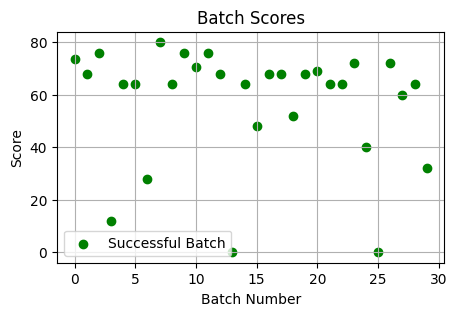

In [11]:
import matplotlib.pyplot as plt

# trial_logs = compiled_model.trial_logs

def plot_model_logs(trial_logs):
    # Extracting trial numbers, scores, and pruning status
    trial_numbers = list(trial_logs.keys())
    scores = [trial_logs[trial]['score'] for trial in trial_numbers]
    pruning_status = [trial_logs[trial]['pruned'] for trial in trial_numbers]

    # Plot setup
    plt.figure(figsize=(5, 3))

    # Plotting each point
    for trial_number, score, pruned in zip(trial_numbers, scores, pruning_status):
        if pruned:
            plt.scatter(trial_number, score, color='grey', label='Pruned Batch' if 'Pruned Batch' not in plt.gca().get_legend_handles_labels()[1] else "")
        else:
            plt.scatter(trial_number, score, color='green', label='Successful Batch' if 'Successful Batch' not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.xlabel('Batch Number')
    plt.ylabel('Score')
    plt.title('Batch Scores')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_model_logs(compiled_model.trial_logs)

In [12]:
def print_model_logs(model, compiled_model):
    # Init constant
    best_score = 0

    def get_signature(predictor):
        if (hasattr(predictor, 'extended_signature')):
            return predictor.extended_signature
        elif (hasattr(predictor, 'signature')):
            return predictor.signature

    print(f"Baseline program | Score: {best_score}:")
    for i,predictor in enumerate(model.predictors()):
        print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
    print()

    print("----------------")

    for trial_num in compiled_model.trial_logs:
        program_score = compiled_model.trial_logs[trial_num]["score"]
        program_pruned = compiled_model.trial_logs[trial_num]["pruned"]
        if program_score > best_score and not program_pruned and compiled_model.trial_logs[trial_num]["full_eval"]:
            best_score = program_score
            best_program_so_far = compiled_model.trial_logs[trial_num]["program"]
        if trial_num % 5 == 0:
            print(f"Best program after {trial_num} batches | Score: {best_score}:")
            for i,predictor in enumerate(best_program_so_far.predictors()):
                print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
            print()

print_model_logs(cot, compiled_model)

Baseline program | Score: 0:
Prompt 1 Instruction: Classify user feedback from hackathon to one single theme

----------------
Best program after 0 batches | Score: 73.77:
Prompt 1 Instruction: ## PROPOSED INSTRUCTION:

Analyze the provided hackathon user feedback and, based on it, provide a step-by-step explanation (Chain of Thought) for why the feedback aligns with a single theme among the following options: 

* Technical Learning Resources
* Clarity of Requirements
* Time Commitment / Workload
* Showcase / Presentation Format
* Communication and Information Sharing
* Team Formation and Dynamics
* Relevance of Training Content
* Application to Business / Use Cases
* Accessibility and Inclusion
* Incentives and Recognition
* Post-Hackathon Follow-up
* Support from Leadership / Mentors 
 
Then, list the corresponding theme in your output. Remember to follow the provided structure:

"Reasoning: [explain your reasoning for choosing a specific theme] 
Themes: [selected theme based on your

In [13]:
import cloudpickle as pickle

LOAD_PRECOMPILED_MODEL = True

# saving trial logs
def save_trial_logs(model, outputfile="trial_logs"):        
    logs = {
        index: {key: value for key, value in item.items() if key != "program"}
        for index, item in model.trial_logs.items()
    }
    
    with open(f"{outputfile}.pickle", "wb") as file:
        pickle.dump(logs, file)

# loading trial logs
def load_trial_logs(inputfile="trial_logs"):
    with open(f"{inputfile}.pickle", "rb") as file:
        logs = pickle.load(file)
    
    return logs

if LOAD_PRECOMPILED_MODEL:
    loaded_model = cot.deepcopy()
    loaded_model.load('compiled_model.dspy')
    trial_logs = load_trial_logs()
    loaded_model.trial_logs = trial_logs


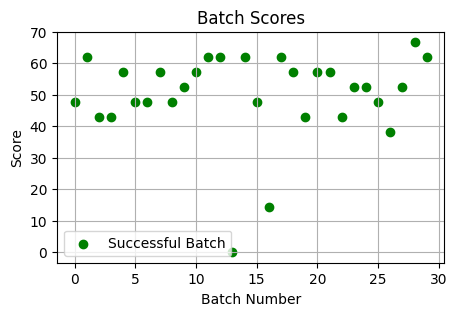

In [15]:
plot_model_logs(loaded_model.trial_logs)

In [37]:
# loaded_model.forward(
#     "The topic and content was very interesting and the opportunity to connect with technical and commercial mentors was great! In the future, it would be great to see either more structure to the hackathon, or more communication about the structure of the hackathon."
# )
data = pd.read_csv("./golden_dataset.csv")


# pred.answer.strip("**")
# # data
data["prediction"] = None
for index, row in data.iterrows():
    if isinstance(row["comments"], str):        
        prediction = loaded_model.forward(row["comments"])
        # # print(prediction.answer.strip("**"))
        data.at[index, "prediction"] = prediction.answer.strip("**")
            
data.to_csv('data.csv')